In [2]:
!pip install imblearn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.3/199.3 kB 4.0 MB/s eta 0:00:0000:01


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import geopandas as gpd

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import top_k_accuracy_score, make_scorer
from sklearn.model_selection import train_test_split
#from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, roc_curve
from GLC.metrics import predict_top_30_set, top_k_error_rate_from_sets, top_30_error_rate
from joblib import dump, load

import imblearn
import folium

sns.set_style("darkgrid")

## Import data

In [3]:
env_vectors = pd.read_csv('input/environmental_vectors.csv', delimiter=';', index_col=0)
train = pd.read_csv('input/observations/observations_fr_train.csv', delimiter=';', index_col=0)
train_env = env_vectors.join(train, how='right')
print(f'Shape of full train data: {train_env.shape}')

Shape of full train data: (671244, 31)


In [490]:
count_by_species2 = train_env['species_id'].value_counts()

In [573]:
ranked_species = count_by_species2.reset_index().reindex(range(1,len(count_by_species2))).rename(columns={'index' : 'specie_id', 'species_id' : 'count'})

Text(0, 0.5, 'Number of observations')

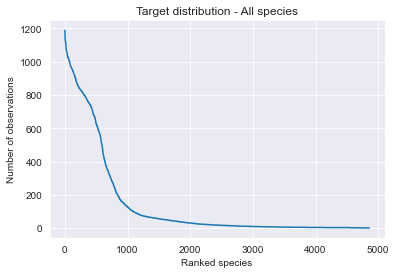

In [574]:
sns.lineplot(x=ranked_species.index, y=ranked_species['count'])
plt.title('Target distribution - All species')
plt.xlabel('Ranked species')
plt.ylabel('Number of observations')

Text(0, 0.5, 'Number of observations')

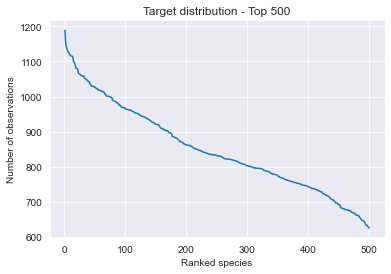

In [576]:
ranked_species_top500 = ranked_species.iloc[:500]

sns.lineplot(x=ranked_species_top500.index, y=ranked_species_top500['count'])
plt.title('Target distribution - Top 500')
plt.xlabel('Ranked species')
plt.ylabel('Number of observations')

Text(0, 0.5, 'Number of species')

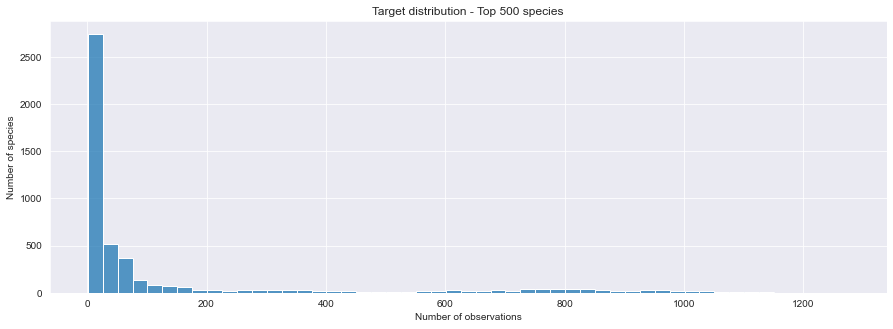

In [493]:
plt.figure(figsize=(15,5))
sns.histplot(x=count_by_species2.values, binwidth=25)
plt.title('Target distribution - Top 500 species')
plt.xlabel('Number of observations')
plt.ylabel('Number of species')

## Select top 500

In [4]:
top500 = train_env['species_id'].value_counts()[:500].index.values
train_env['top500'] = train_env['species_id'].apply(lambda x : True if x in top500 else False)
train_env_top500 = train_env[train_env['top500'] == True].copy()
print(f'Shape of top500 train data: {train_env_top500.shape}')

Shape of top500 train data: (425912, 32)


In [222]:
count_by_species = train_env_top500['species_id'].value_counts()

In [244]:
count_by_species

565    1265
21     1189
678    1160
251    1143
793    1138
       ... 
771     633
606     633
877     633
163     628
543     627
Name: species_id, Length: 500, dtype: int64

In [ ]:
count_by_species.groupby

Text(0, 0.5, 'Number of species')

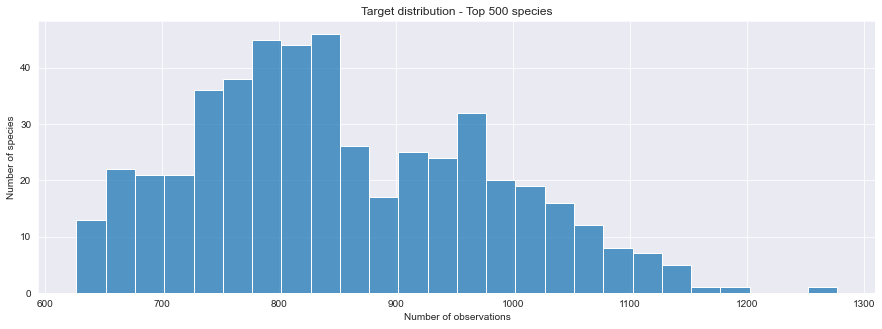

In [6]:
plt.figure(figsize=(15,5))
sns.histplot(x=count_by_species.values, binwidth=25)
plt.title('Target distribution - Top 500 species')
plt.xlabel('Number of observations')
plt.ylabel('Number of species')

Text(0.5, 0, 'Number of species')

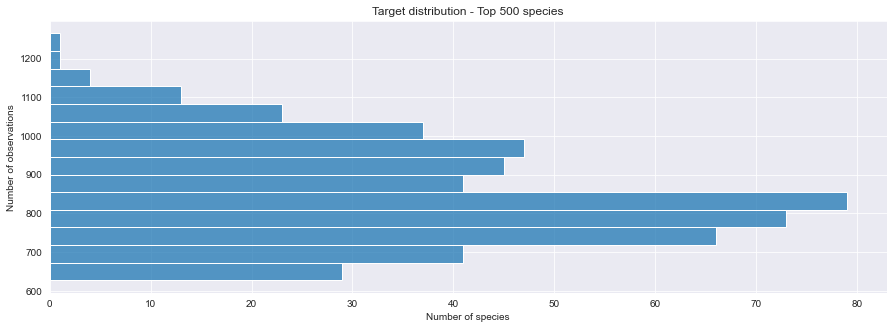

In [232]:
plt.figure(figsize=(15,5))
sns.histplot(y=count_by_species.values)
plt.title('Target distribution - Top 500 species')
plt.ylabel('Number of observations')
plt.xlabel('Number of species')

## Train model function

In [386]:
def train(data, n_estimators, max_depth) :

    X_train = data[data['subset'] == 'train'].iloc[:,:-3].values
    y_train = data[data['subset'] == 'train'].iloc[:,-3].values

    X_val = data[data['subset'] == 'val'].iloc[:,:-3].values
    y_val = data[data['subset'] == 'val'].iloc[:,-3].values

    # Imputation
    imp = SimpleImputer()
    X_train = imp.fit_transform(X_train)
    X_val = imp.transform(X_val)

    # Scaling
    sc = StandardScaler()
    X_train = sc.fit_transform(X_train)
    X_val = sc.transform(X_val)

    classifier = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, n_jobs=-1)
    classifier.fit(X_train, y_train)
    
    y_train_pred_proba = classifier.predict_proba(X_train)
    y_val_pred_proba = classifier.predict_proba(X_val)
    score_train = top_k_accuracy_score(y_train,y_train_pred_proba, k=30, labels=classifier.classes_)
    score_val = top_k_accuracy_score(y_val,y_val_pred_proba, k=30, labels=classifier.classes_)
    
    return classifier, score_train, score_val

## Manual grid search

In [ ]:
X_train = train_env_top500[train_env_top500['subset'] == 'train'].iloc[:,:-3].values
y_train = train_env_top500[train_env_top500['subset'] == 'train'].iloc[:,-3].values

X_val = train_env_top500[train_env_top500['subset'] == 'val'].iloc[:,:-3].values
y_val = train_env_top500[train_env_top500['subset'] == 'val'].iloc[:,-3].values

# Imputation
imp = SimpleImputer()
X_train = imp.fit_transform(X_train)
X_val = imp.transform(X_val)

# Scaling
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_val = sc.transform(X_val)

n_estimators_list = np.arange(75,130,5)
max_depth_list = np.arange(5,15,2)
combinations = [(x,y) for x in n_estimators_list for y in max_depth_list]

results = []
i=0
for n_estimators, max_depth in combinations:
        i+=1
        print(f'Fitting {i}/{len(combinations)} ==> n_estimators={n_estimators}, max_depth={max_depth}')
        
        # Fitting the classifier
        classifier = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth)
        classifier.fit(X_train, y_train)
        
        # Predict probabilities of each class
        y_train_pred_proba = classifier.predict_proba(X_train)
        y_val_pred_proba = classifier.predict_proba(X_val)
        
        # Calculate top30 accuracy score
        score_train = top_k_accuracy_score(y_train,y_train_pred_proba, k=30, labels=classifier.classes_)
        score_val = top_k_accuracy_score(y_val,y_val_pred_proba, k=30, labels=classifier.classes_)
        print(f'Score train: {score_train}, score val: {score_val}')
        
        # Save the results
        results.append({'n_estimators' : n_estimators, 'max_depth' : max_depth, 'top_30_accuracy_score_train' : score_train, 'top_30_accuracy_score' : score_val})
        
results
#classifier = GridSearchCV(estimator = rf_classifier_grid, param_grid = params, verbose=1)
#classifier.fit(X_train, y_train)

#dump(classifier, 'rf_gridsearch.joblib') 

In [19]:
sorted_results = sorted(results, key=lambda d: d['top_30_accuracy_score'], reverse=True) 
sorted_results[:5]

[{'n_estimators': 115,
  'max_depth': 13,
  'top_30_accuracy_score_train': 0.5438767152571115,
  'top_30_accuracy_score': 0.29785900783289815},
 {'n_estimators': 95,
  'max_depth': 11,
  'top_30_accuracy_score_train': 0.42490098165668677,
  'top_30_accuracy_score': 0.29629242819843343},
 {'n_estimators': 120,
  'max_depth': 13,
  'top_30_accuracy_score_train': 0.5498334282083985,
  'top_30_accuracy_score': 0.29629242819843343},
 {'n_estimators': 100,
  'max_depth': 13,
  'top_30_accuracy_score_train': 0.5396661838846896,
  'top_30_accuracy_score': 0.2951436031331593},
 {'n_estimators': 80,
  'max_depth': 13,
  'top_30_accuracy_score_train': 0.5306710669481693,
  'top_30_accuracy_score': 0.29493472584856395}]

## Best model according to grid search

In [369]:
classifier, score_train, score_val = train(train_env_top500, 95, 13)

#joblib.dump(classifier, 'RF_model.sav')
print(f'Train test score: {score_train}')
print(f'Val test score: {score_val}')
classifier.feature_importances_

Train test score: 0.5379320118077423
Val test score: 0.29556135770234987


array([0.03750233, 0.02936542, 0.03177996, 0.03424303, 0.021059  ,
       0.02330839, 0.02507557, 0.02778048, 0.02956065, 0.03204561,
       0.03303009, 0.02734264, 0.01951007, 0.0215696 , 0.03644592,
       0.02473242, 0.02298846, 0.0226062 , 0.02446762, 0.04656498,
       0.04886561, 0.03056186, 0.02823468, 0.03950357, 0.03796095,
       0.0279849 , 0.03233389, 0.09187143, 0.09170469])

## PCA

In [28]:
from sklearn.decomposition import PCA
pca = PCA(n_components=0.95)
PC_train = pca.fit_transform(X_train)
PC_val = pca.transform(X_val)

In [27]:
pca.explained_variance_ratio_

array([0.3255179 , 0.17906547, 0.16375413, 0.08803593, 0.0608319 ,
       0.03894933, 0.03732096, 0.02639808, 0.01602273, 0.0140772 ,
       0.01132761])

In [39]:
classifier = RandomForestClassifier(n_estimators=100, max_depth=11, max_features=5, min_samples_leaf=5)
classifier.fit(PC_train, y_train)

RandomForestClassifier(max_depth=11, max_features=5, min_samples_leaf=5)

In [40]:
# Predict probabilities of each class
y_train_pred_proba = classifier.predict_proba(PC_train)
y_val_pred_proba = classifier.predict_proba(PC_val)
        
# Calculate top30 accuracy score
score_train = top_k_accuracy_score(y_train,y_train_pred_proba, k=30, labels=classifier.classes_)
score_val = top_k_accuracy_score(y_val,y_val_pred_proba, k=30, labels=classifier.classes_)
print(f'Score train: {score_train}, score val: {score_val}')

Score train: 0.4540312295087873, score val: 0.28407310704960836


## Count observations by region

In [488]:
regions = gpd.read_file('input/regions.geojson')
regions = regions[~regions['code'].isin(['01', '02', '03', '04', '06'])]

observations_top500 = gpd.GeoDataFrame(train_env_top500, geometry=gpd.points_from_xy(train_env_top500['longitude'], train_env_top500['latitude']), crs='WGS 84')

joined_df = gpd.sjoin(
    observations_top500,
    regions,
    how='inner',
    predicate='intersects',
)

regions_count_observations = joined_df.groupby(
    ['nom'], 
    as_index=False,
)['bio_1'].count()
# groupby to count the wifi locations in each community district
# arbitrarily count the rows for doitt_id
regions_count_observations.columns = ['region', 'count_observations']  # rename the column

regions_count_observations=regions.merge(regions_count_observations, left_on='nom', right_on='region')

In [489]:
regions_count_observations['centroid_x'] = regions_count_observations['geometry'].centroid.x
regions_count_observations['centroid_y'] = regions_count_observations['geometry'].centroid.y

m=folium.Map(
    location=[regions_count_observations['centroid_x'].mean(), regions_count_observations['centroid_y'].mean()], 
    zoom_start=6, 
    tiles='cartodbpositron')

def get_radius(count):
    return int(count / 1000)

#sets style of Choropleth
style_function = lambda x: {"weight":0.4,
                            "color":'black',
                            "opacity":1,
                            #"fillColor":colormap(x['properties']['gi']), 
                            'fillOpacity':0.0
                           }

folium.GeoJson(data=regions["geometry"], style_function=style_function).add_to(m)

regions_count_observations.apply(
    lambda row: folium.CircleMarker(
        location=[row['centroid_y'], row['centroid_x']],
        radius=get_radius(row['count_observations']),
        stroke=True,
        weight=1,
        color="#3186cc",
        fill=True,
        fill_color="#3186cc",
        opacity=0.9,
        fill_opacity=0.3,
        tooltip=row['count_observations']
        ).add_to(m),
    axis=1)


m

/var/folders/rr/8n3z7wv528lcwz1220m1w10c0000gn/T/ipykernel_2131/1512161937.py:1: UserWarning:

Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.


/var/folders/rr/8n3z7wv528lcwz1220m1w10c0000gn/T/ipykernel_2131/1512161937.py:2: UserWarning:

Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.




## Correlation

In [147]:
corr = train_env_top500.iloc[:,:-9].corr().abs()
s = corr.unstack()
so = s.sort_values(kind="quicksort", ascending=False)
so = so[(so > 0.75) & (so<1)]
so.iloc[list(range(0,len(so), 2))]

<AxesSubplot:>

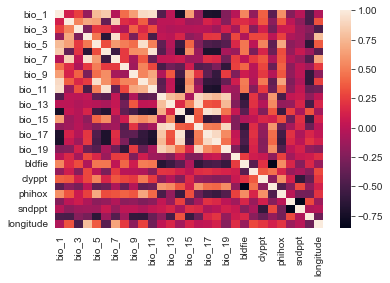

In [131]:
sns.heatmap(train_env_top500.iloc[:,:-9].corr())

## Remove most correlated features

### Iteration 2

In [387]:
to_drop = ['sndppt', 'bldfie', 'bio_17', 'bio_6', 'bio_5']
train_env_top500_2 = train_env_top500.drop(columns=to_drop)

In [388]:
classifier_2, score_train_2, score_val_2 = train(train_env_top500_2, 95, 13)

print(f'Train test score: {score_train_2}')
print(f'Val test score: {score_val_2}')

Train test score: 0.5577717089761419
Val test score: 0.2935770234986945


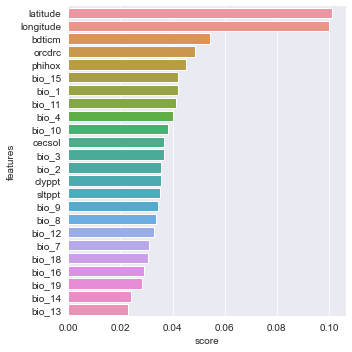

In [389]:
feature_importance_2 = pd.DataFrame({"features": train_env_top500_2.iloc[:,:-3].columns.values, "score": classifier_2.feature_importances_}).sort_values(by="score", ascending=False)
sns.catplot(x="score",y="features", data=feature_importance_2, kind="bar" )

### Iteration 3

In [390]:
to_drop = feature_importance_2.iloc[-14:]['features'].values
train_env_top500_3 = train_env_top500_2.drop(columns=to_drop)

classifier_3, score_train_3, score_val_3 = train(train_env_top500_3, 95, 13)

print(f'Train test score: {score_train_3}')
print(f'Val test score: {score_val_3}')

Train test score: 0.5397694656011837
Val test score: 0.28992167101827676


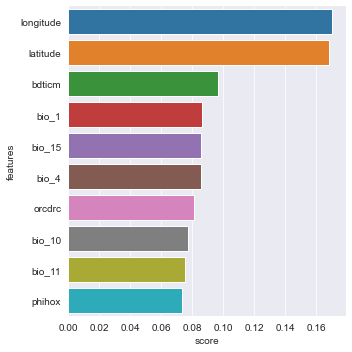

In [391]:
feature_importance_3 = pd.DataFrame({"features": train_env_top500_3.iloc[:,:-3].columns.values, "score": classifier_3.feature_importances_}).sort_values(by="score", ascending=False)
sns.catplot(x="score",y="features", data=feature_importance, kind="bar" )

### Iteration 4

In [392]:
to_drop = feature_importance_3[~feature_importance_3['features'].isin(['latitude', 'longitude'])]['features'].values
train_env_top500_4 = train_env_top500_3.drop(columns=to_drop)

classifier_4, score_train_4, score_val_4 = train(train_env_top500_4, 95, 13)

print(f'Train test score: {score_train_4}')
print(f'Val test score: {score_val_4}')

Train test score: 0.6361433165920877
Val test score: 0.27488250652741514


## Undersampling
### Random undersampling 

In [7]:
from collections import Counter
from imblearn.under_sampling import RandomUnderSampler

In [8]:
def train_random_split(X, y , n_estimators, max_depth, min_samples_leaf) :

    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

    # Imputation
    imp = SimpleImputer()
    X_train = imp.fit_transform(X_train)
    X_val = imp.transform(X_val)

    # Scaling
    sc = StandardScaler()
    X_train = sc.fit_transform(X_train)
    X_val = sc.transform(X_val)

    classifier = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, min_samples_leaf=min_samples_leaf, n_jobs=-1)
    classifier.fit(X_train, y_train)
    
    y_train_pred_proba = classifier.predict_proba(X_train)
    
    y_val_pred_proba = classifier.predict_proba(X_val)
    
    score_train = top_k_accuracy_score(y_train,y_train_pred_proba, k=30, labels=classifier.classes_)
    score_val = top_k_accuracy_score(y_val,y_val_pred_proba, k=30, labels=classifier.classes_)
    
    return classifier, score_train, score_val

In [9]:
rus = RandomUnderSampler(random_state=42, replacement=True)

In [10]:
X = train_env_top500.iloc[:,:-3]
y = train_env_top500.iloc[:,-3]

X_rus, y_rus = rus.fit_resample(X, y)

In [ ]:
classifier_rus, score_train_rus, score_val_rus = train_random_split(X_rus, y_tl , 95, 13)
print(f'Train test score: {score_train_rus}')
print(f'Val test score: {score_val_rus}')

Train test score: 0.6152711323763955
Val test score: 0.42543859649122806


In [578]:
env_variables= pd.read_csv('input/metadata/environmental_variables.csv', delimiter=';', index_col=0)

In [577]:
column_description = [env_variables.loc[column_id, 'description'] if column_id in env_variables.index else column_id for column_id in X.columns]

In [533]:
feature_importance_rus = pd.DataFrame({"features": column_description, "score": classifier_rus.feature_importances_}).sort_values(by="score", ascending=False)

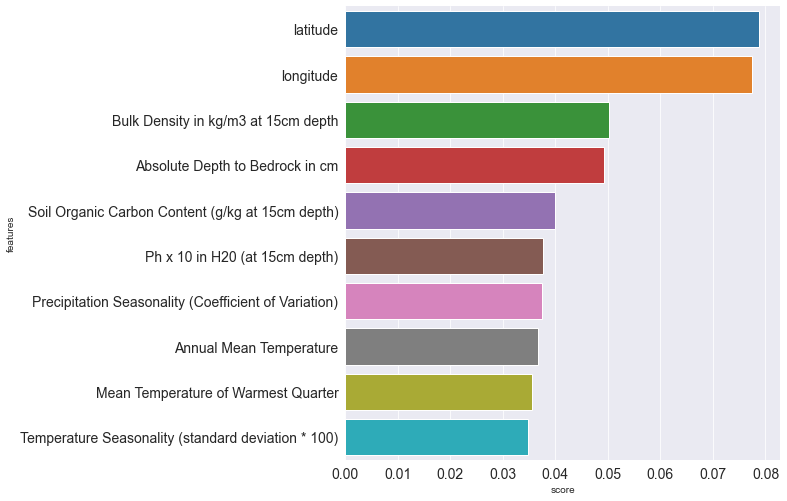

In [552]:
#plt.figure(figsize=(30,30))
sns.catplot(x="score",y="features", data=feature_importance_rus.iloc[:10], kind="bar" , height=7, aspect = 1.4)
plt.tick_params(axis='both', which='major', labelsize=14)

In [582]:
rus_df = pd.concat([X_rus, y_rus], axis=1)
count_by_species_rus = rus_df['species_id'].value_counts()
ranked_species_rus = count_by_species_rus.reset_index().reindex(range(1,len(count_by_species_rus))).rename(columns={'index' : 'specie_id', 'species_id' : 'count'})

Text(0, 0.5, 'Number of observations')

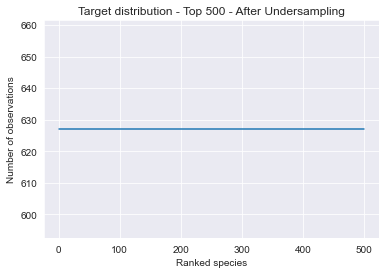

In [585]:
sns.lineplot(x=ranked_species_rus.index, y=ranked_species_rus['count'])
plt.title('Target distribution - Top 500 - After Undersampling')
plt.xlabel('Ranked species')
plt.ylabel('Number of observations')

In [586]:
regions = gpd.read_file('input/regions.geojson')
regions = regions[~regions['code'].isin(['01', '02', '03', '04', '06'])]

observations_top500_rus = gpd.GeoDataFrame(rus_df, geometry=gpd.points_from_xy(rus_df['longitude'], rus_df['latitude']), crs='WGS 84')

joined_df_rus = gpd.sjoin(
    observations_top500_rus,
    regions,
    how='inner',
    predicate='intersects',
)

regions_count_observations_rus = joined_df_rus.groupby(
    ['nom'], 
    as_index=False,
)['bio_1'].count()
# groupby to count the wifi locations in each community district
# arbitrarily count the rows for doitt_id
regions_count_observations_rus.columns = ['region', 'count_observations']  # rename the column

regions_count_observations_rus=regions.merge(regions_count_observations_rus, left_on='nom', right_on='region')

In [589]:
regions_count_observations_rus['centroid_x'] = regions_count_observations_rus['geometry'].centroid.x
regions_count_observations_rus['centroid_y'] = regions_count_observations_rus['geometry'].centroid.y

m=folium.Map(
    location=[regions_count_observations_rus['centroid_y'].mean(), regions_count_observations_rus['centroid_x'].mean()], 
    zoom_start=6, 
    tiles='cartodbpositron')

def get_radius(count):
    return int(count / 1000)

#sets style of Choropleth
style_function = lambda x: {"weight":0.4,
                            "color":'black',
                            "opacity":1,
                            #"fillColor":colormap(x['properties']['gi']), 
                            'fillOpacity':0.0
                           }

folium.GeoJson(data=regions["geometry"], style_function=style_function).add_to(m)

regions_count_observations_rus.apply(
    lambda row: folium.CircleMarker(
        location=[row['centroid_y'], row['centroid_x']],
        radius=get_radius(row['count_observations']),
        stroke=True,
        weight=1,
        color="#3186cc",
        fill=True,
        fill_color="#3186cc",
        opacity=0.9,
        fill_opacity=0.3,
        tooltip=row['count_observations']
        ).add_to(m),
    axis=1)


m
m.save("index.html")

/var/folders/rr/8n3z7wv528lcwz1220m1w10c0000gn/T/ipykernel_2131/110048819.py:1: UserWarning:

Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.


/var/folders/rr/8n3z7wv528lcwz1220m1w10c0000gn/T/ipykernel_2131/110048819.py:2: UserWarning:

Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.




### TomekLinks

In [459]:
from imblearn.under_sampling import TomekLinks

tl = TomekLinks(sampling_strategy='majority')

X = train_env_top500.iloc[:,:-3]
y = train_env_top500.iloc[:,-3]

imp = SimpleImputer()
X = imp.fit_transform(X)

# fit predictor and target variable
X_tl, y_tl = tl.fit_resample(X, y)

In [466]:
classifier_tl, score_train_tl, score_val_tl = train_random_split(X_tl, y_tl , 95, 13)
print(f'Train test score: {score_train_tl}')
print(f'Val test score: {score_val_tl}')

Train test score: 0.5553547234247659
Val test score: 0.32116196231028765


In [461]:
X.shape

(425912, 29)

In [462]:
X_tl.shape

(425314, 29)

### Grid search with undersampled data

In [632]:
X_train, X_val, y_train, y_val = train_test_split(X_rus, y_rus, test_size=0.2, random_state=42, stratify = y_rus)

# Imputation
imp = SimpleImputer()
X_train = imp.fit_transform(X_train)
X_val = imp.transform(X_val)

# Scaling
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_val = sc.transform(X_val)

In [651]:
from sklearn.model_selection import GridSearchCV

params = {"n_estimators": [90, 110], 
          "max_depth": [15, 20],
          "min_samples_leaf" : [5]}

#params = {"n_estimators": [10], "max_depth": [10]}
top_30_scorer = make_scorer(top_k_accuracy_score, k=30, labels=np.unique(y_rus), needs_proba=True)
classifier = GridSearchCV(cv=5, estimator = RandomForestClassifier(n_jobs=-1), param_grid = params, n_jobs = -1, verbose = 3, scoring = top_30_scorer).fit(X_train, y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV 5/5] END max_depth=15, min_samples_leaf=5, n_estimators=90;, score=0.475 total time= 3.9min
[CV 2/5] END max_depth=20, min_samples_leaf=5, n_estimators=90;, score=0.540 total time= 3.9min
[CV 5/5] END max_depth=20, min_samples_leaf=5, n_estimators=110;, score=0.541 total time= 2.4min
[CV 4/5] END max_depth=15, min_samples_leaf=5, n_estimators=90;, score=0.478 total time= 3.9min
[CV 3/5] END max_depth=20, min_samples_leaf=5, n_estimators=90;, score=0.537 total time= 4.0min
[CV 3/5] END max_depth=15, min_samples_leaf=5, n_estimators=110;, score=0.477 total time= 4.0min
[CV 4/5] END max_depth=20, min_samples_leaf=5, n_estimators=90;, score=0.538 total time= 4.0min
[CV 1/5] END max_depth=15, min_samples_leaf=5, n_estimators=110;, score=0.485 total time= 4.0min
[CV 5/5] END max_depth=20, min_samples_leaf=5, n_estimators=90;, score=0.535 total time= 4.0min
[CV 2/5] END max_depth=15, min_samples_leaf=5, n_estimators=110;, score=0

In [652]:
classifier.best_params_

{'max_depth': 20, 'min_samples_leaf': 5, 'n_estimators': 110}

In [656]:
classifier.best_score_

0.5418221690590113

In [654]:
y_train_pred_proba = classifier.best_estimator_.predict_proba(X_train)
y_val_pred_proba = classifier.best_estimator_.predict_proba(X_val)
score_train = top_k_accuracy_score(y_train,y_train_pred_proba, k=30, labels=classifier.best_estimator_.classes_)
score_val = top_k_accuracy_score(y_val,y_val_pred_proba, k=30, labels=classifier.best_estimator_.classes_)

print(f'Train test score: {score_train}')
print(f'Val test score: {score_val}')

Train test score: 0.948317384370016
Val test score: 0.5849920255183413


In [660]:
train_random_split(X_rus, y_rus , 110, 20, 5)

(RandomForestClassifier(max_depth=20, min_samples_leaf=5, n_estimators=110,
                        n_jobs=-1),
 0.9463556618819776,
 0.5872248803827751)

In [661]:
train_random_split(X_rus, y_rus , 110, 15, 5)

(RandomForestClassifier(max_depth=15, min_samples_leaf=5, n_estimators=110,
                        n_jobs=-1),
 0.7801714513556619,
 0.5029505582137161)

In [16]:
train_random_split(X_rus, y_rus , 150, 15, 5)

(RandomForestClassifier(max_depth=15, min_samples_leaf=5, n_estimators=150,
                        n_jobs=-1),
 0.7903349282296651,
 0.509585326953748)

In [11]:
cor_matrix = train_env_top500.corr().abs()
upper_tri = cor_matrix.where(np.triu(np.ones(cor_matrix.shape),k=1).astype(bool))

In [12]:
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.9)]
print(to_drop)

['bio_7', 'bio_10', 'bio_11', 'bio_16', 'bio_17', 'bio_18']


In [13]:
X_rus_2 = X_rus.drop(columns=to_drop)
X_rus_2.head()

,bio_1,bio_2,bio_3,bio_4,bio_5,bio_6,bio_8,bio_9,bio_12,bio_13,...,bdticm,bldfie,cecsol,clyppt,orcdrc,phihox,sltppt,sndppt,latitude,longitude
0,9.604167,9.208333,34.359450,639.2519,24.7,-2.1,10.066667,17.716667,1082.0,113.0,...,1597.0,1202.0,24.0,23.0,36.0,60.0,38.0,39.0,45.056545,5.378586
1,10.033334,10.550000,37.678574,635.3465,26.0,-2.0,10.650001,18.183334,958.0,118.0,...,1847.0,1316.0,23.0,27.0,25.0,73.0,42.0,31.0,44.024876,5.493743
2,10.483334,7.883333,35.037037,542.0682,23.5,1.0,7.483334,6.700000,640.0,62.0,...,1421.0,1416.0,16.0,25.0,16.0,73.0,52.0,24.0,49.087490,1.873600
3,11.116667,10.150000,35.992910,651.4018,27.2,-1.0,11.566667,19.500000,966.0,123.0,...,2350.0,1270.0,23.0,27.0,28.0,69.0,38.0,35.0,44.310276,5.151945
4,10.891666,10.200000,35.172417,684.4070,26.8,-2.2,11.050000,6.783333,977.0,98.0,...,1724.0,1267.0,22.0,26.0,40.0,64.0,36.0,38.0,45.537540,6.101907


In [14]:
classifier_rus, score_train_rus, score_val_rus = train_random_split(X_rus_2, y_rus , 200, 20, 5)
print(f'Train test score: {score_train_rus}')
print(f'Val test score: {score_val_rus}')

Train test score: 0.9668819776714513
Val test score: 0.5994098883572567


In [22]:
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier


#cross_val_score(clf, iris.data, iris.target, cv=10)

X_train, X_val, y_train, y_val = train_test_split(X_rus, y_rus, test_size=0.2, random_state=42)

# Imputation
imp = SimpleImputer()
X_train = imp.fit_transform(X_train)
X_val = imp.transform(X_val)

# Scaling
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_val = sc.transform(X_val)

classifier = DecisionTreeClassifier(max_depth=20, min_samples_split=5)
classifier.fit(X_train, y_train)
    
y_train_pred_proba = classifier.predict_proba(X_train)
    
y_val_pred_proba = classifier.predict_proba(X_val)
    
score_train = top_k_accuracy_score(y_train,y_train_pred_proba, k=30, labels=classifier.classes_)
score_val = top_k_accuracy_score(y_val,y_val_pred_proba, k=30, labels=classifier.classes_)

In [23]:
print(f'Train test score: {score_train}')
print(f'Val test score: {score_val}')

Train test score: 0.4182137161084529
Val test score: 0.28604465709728866


## Graphs for powerpoint

In [476]:
from GLC.plotting import visualize_observation_patch

In [479]:
df_suggested_landcover_alignment = pd.read_csv('input/metadata/landcover_suggested_alignment.csv', sep=";")

In [482]:
from GLC.data_loading.common import load_patch

patch = load_patch(10131188, 'input')

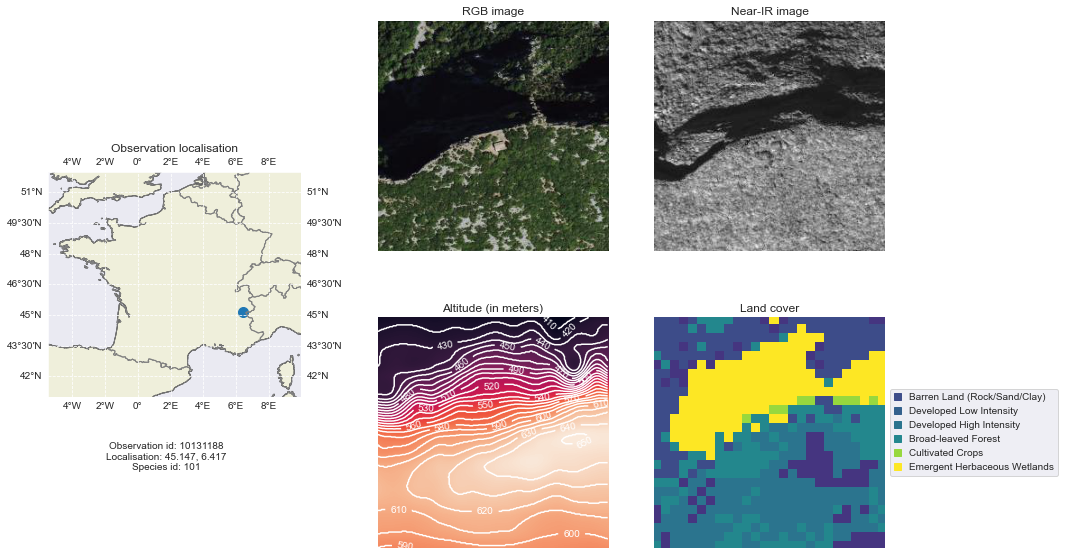

In [486]:
landcover_labels = df_suggested_landcover_alignment[["suggested_landcover_code", "suggested_landcover_label"]].drop_duplicates().sort_values("suggested_landcover_code")["suggested_landcover_label"].values

visualize_observation_patch(patch, observation_data=train_env_top500.loc[10131188], landcover_labels=landcover_labels)

In [616]:
column_description = [env_variables.loc[column_id, 'description'] if column_id in env_variables.index else column_id for column_id in train_env_top500.drop(columns=['subset', 'top500', 'geometry']).columns]

df = pd.DataFrame(column_description)
df['env_var'] = train_env_top500.drop(columns=['subset', 'top500', 'geometry']).loc[10131188].values

In [619]:
df.set_index(0)['env_var']

0
Annual Mean Temperature                                          4.587500
Mean Diurnal Range (Mean of monthly (max temp - min temp))       9.058333
Isothermality (bio_2/bio_7) (* 100)                             33.302696
Temperature Seasonality (standard deviation * 100)             664.602200
Max Temperature of Warmest Month                                19.900000
Min Temperature of Coldest Month                                -7.300000
Temperature Annual Range (bio_5-bio_6)                          27.200000
Mean Temperature of Wettest Quarter                              1.416667
Mean Temperature of Driest Quarter                              12.800000
Mean Temperature of Warmest Quarter                             12.833333
Mean Temperature of Coldest Quarter                             -3.150000
Annual Precipitation                                          1323.000000
Precipitation of Wettest Month                                 141.000000
Precipitation of Driest Month       

In [614]:
column_description

['Annual Mean Temperature',
 'Mean Diurnal Range (Mean of monthly (max temp - min temp))',
 'Isothermality (bio_2/bio_7) (* 100)',
 'Temperature Seasonality (standard deviation * 100)',
 'Max Temperature of Warmest Month',
 'Min Temperature of Coldest Month',
 'Temperature Annual Range (bio_5-bio_6)',
 'Mean Temperature of Wettest Quarter',
 'Mean Temperature of Driest Quarter',
 'Mean Temperature of Warmest Quarter',
 'Mean Temperature of Coldest Quarter',
 'Annual Precipitation',
 'Precipitation of Wettest Month',
 'Precipitation of Driest Month',
 'Precipitation Seasonality (Coefficient of Variation)',
 'Precipitation of Wettest Quarter',
 'Precipitation of Driest Quarter',
 'Precipitation of Warmest Quarter',
 'Precipitation of Coldest Quarter',
 'Absolute Depth to Bedrock in cm',
 'Bulk Density in kg/m3 at 15cm depth',
 'Cation Exchange Capacity of Soil in cmolc/kg 15cm depth ',
 'Clay (0-2 micro meter) Mass Fraction at 15cm depth',
 'Soil Organic Carbon Content (g/kg at 15cm dept

## Random bits of code

In [325]:
env_vectors = pd.read_csv('input/environmental_vectors.csv', delimiter=';', index_col=0)
test = pd.read_csv('input/observations/observations_fr_test.csv', delimiter=';', index_col=0, nrows=5)
test_env = env_vectors.join(test, how='right')
species_details = pd.read_csv('input/metadata/species_details.csv', delimiter=';', index_col=0)
classes = {species_id : species_details.loc[species_id, 'GBIF_species_name'] for species_id in clf.classes_}

In [257]:
test_env

,bio_1,bio_2,bio_3,bio_4,bio_5,bio_6,bio_7,bio_8,bio_9,bio_10,...,bdticm,bldfie,cecsol,clyppt,orcdrc,phihox,sltppt,sndppt,latitude,longitude
observation_id,,,,,,,,,,,,,,,,,,,,,
10782781,14.837500,8.175000,34.639830,562.34546,27.5,3.9,23.600000,11.983334,21.983334,22.033333,...,1591.0,1375.0,15.0,23.0,20.0,69.0,34.0,43.0,43.601788,6.940195
10364138,11.854167,9.075000,38.453392,551.89530,25.4,1.8,23.600000,6.100000,18.833334,18.833334,...,1326.0,1381.0,18.0,20.0,23.0,63.0,37.0,43.0,46.241711,0.683586
10692017,12.512500,9.741667,38.657410,572.18134,26.8,1.6,25.199999,12.883333,19.750000,19.750000,...,1260.0,1379.0,13.0,26.0,19.0,60.0,40.0,34.0,45.181095,1.533459
10222322,11.170834,8.641666,33.756510,650.43854,25.5,-0.1,25.600000,11.333333,7.233334,19.216667,...,2178.0,1424.0,16.0,23.0,17.0,67.0,41.0,36.0,46.938450,5.298678
10241950,12.250000,9.183333,38.748240,545.07300,25.7,2.0,23.700000,9.166667,19.100000,19.100000,...,1712.0,1319.0,14.0,23.0,23.0,62.0,40.0,38.0,45.017433,0.960736


In [260]:
features=test_env.columns.values

array(['bio_1', 'bio_2', 'bio_3', 'bio_4', 'bio_5', 'bio_6', 'bio_7',
       'bio_8', 'bio_9', 'bio_10', 'bio_11', 'bio_12', 'bio_13', 'bio_14',
       'bio_15', 'bio_16', 'bio_17', 'bio_18', 'bio_19', 'bdticm',
       'bldfie', 'cecsol', 'clyppt', 'orcdrc', 'phihox', 'sltppt',
       'sndppt', 'latitude', 'longitude'], dtype=object)

In [304]:
classes[472]

'Schinus molle'

In [274]:
proba = clf.predict_proba([test_env.iloc[0].values])[0]

In [306]:
df = pd.DataFrame(clf.classes_).rename(columns={0:'specie_id'})
df['proba']= clf.predict_proba([test_env.iloc[0].values])[0]

In [307]:
top30 = df.sort_values(by='proba', ascending=False).iloc[:30]
top30['specie_name'] = top30['specie_id'].apply(lambda x : classes[x])

In [334]:
df = pd.DataFrame.from_dict(classes, orient='index').rename(columns={0:'specie'})
df['proba']= clf.predict_proba([test_env.iloc[0].values])[0]
result = df.sort_values(by='proba', ascending=False).iloc[:30, 0]

In [333]:
list(test_env.iloc[0].values)

[14.8375,
 8.175,
 34.63983,
 562.34546,
 27.5,
 3.9,
 23.6,
 11.983334,
 21.983334,
 22.033333,
 8.45,
 852.0,
 129.0,
 16.0,
 43.632095,
 329.0,
 96.0,
 127.0,
 256.0,
 1591.0,
 1375.0,
 15.0,
 23.0,
 20.0,
 69.0,
 34.0,
 43.0,
 43.6017875671387,
 6.9401950836181605]

In [359]:
import requests

S = requests.Session()
URL = 'https://api.wikimedia.org/core/v1/wikipedia/en/search/page?'

PARAMS = {
    "q": "Daphne gnidium",
    "project": "wikispecies",
    "limit":10
}

R = S.get(url=URL, params=PARAMS)
DATA = R.json()



In [361]:
image_url = DATA['pages'][0]['thumbnail']['url'][2:]
image_url

'upload.wikimedia.org/wikipedia/commons/thumb/5/57/Daphne_gnidium3.jpg/144px-Daphne_gnidium3.jpg'